# Covid - Twitter Sentiment Analysis

In this work we try to classify tweets about Corona Virus into 5 different categories - extremely negative, negative, neutral, positive and extremely positive. 

The data is gathered from Twitter Api and manually labeled. Here's the source of the csv files we use in this work:

[Kaggle dataset](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)

In [1]:
pip install tensorflow-addons

In [73]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout, SpatialDropout1D, Embedding, Flatten, SimpleRNN, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


In [3]:
# Constants

VOCABULARY_SIZE = 20000
MAX_NUM_WORDS = 400
EMBEDDING_DIMENSIONS = 64
BATCH_SIZE = 256
CLASS_NUM = 5
EPOCHS = 100

## EDA and data preparation

In [4]:
data_train = pd.read_csv('/content/drive/MyDrive/datasets/archive (1)/Corona_NLP_train.csv', encoding='latin')
data_test = pd.read_csv('/content/drive/MyDrive/datasets/archive (1)/Corona_NLP_test.csv', encoding='latin')

In [5]:
data_train.shape

(41157, 6)

In [6]:
data_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
19359,23158,68110,"California, USA",24-03-2020,@TerryWhittle4 @ButcherNate1 With the current ...,Negative
39561,43360,88312,#Worldwide #DumpTrump,13-04-2020,Does the outbreak have you worried about stock...,Extremely Negative
38665,42464,87416,"Redmond, WA",12-04-2020,"@AGOWA Bob Ferguson wants YOU to ÂSee it, Sn...",Negative
35264,39063,84015,South Africa,09-04-2020,Redshift recently built an online store connec...,Positive
19795,23594,68546,"48.4222Â° N, 123.3657Â° W",24-03-2020,@omar_degan No fridge or pantry to stock up on...,Negative


In [7]:
grouped_by_sentiment = data_train.groupby('Sentiment').size()

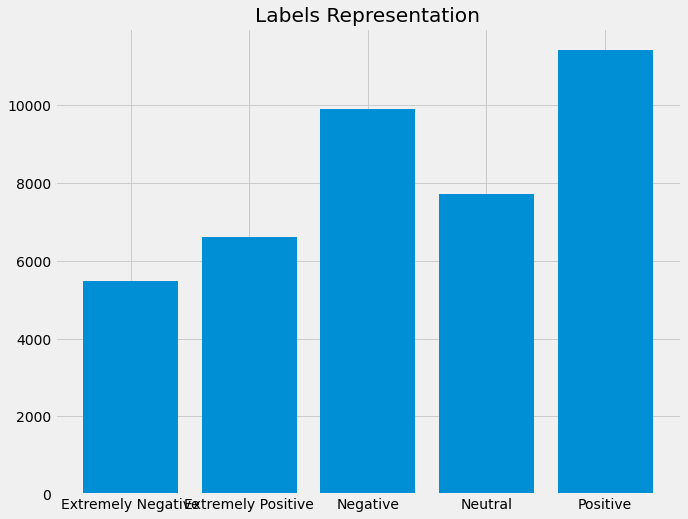

In [8]:
plt.figure(figsize=[10, 8])
plt.bar(grouped_by_sentiment.index, grouped_by_sentiment)
plt.title('Labels Representation');

The data is somewhat unbalanced but it's not that bad. Also we have a lot of observations for each label. We are not going to perform over or undersampling for now until we find some specific problems with particular underrepresented label. 

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


**Getting the columns of interest**

In [10]:
data = data_train[['OriginalTweet', 'Sentiment']]

**Turning strings to numeric**

In [11]:
dictionary_of_sentiments = {'Extremely Negative': 0, 'Neutral': 2, 'Positive': 3, 'Extremely Positive': 4, 'Negative': 1}
data['Sentiment'] = data['Sentiment'].map(dictionary_of_sentiments)
data_test['Sentiment'] = data_test['Sentiment'].map(dictionary_of_sentiments)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
grouped_by_sentiment = data.groupby('Sentiment').size()

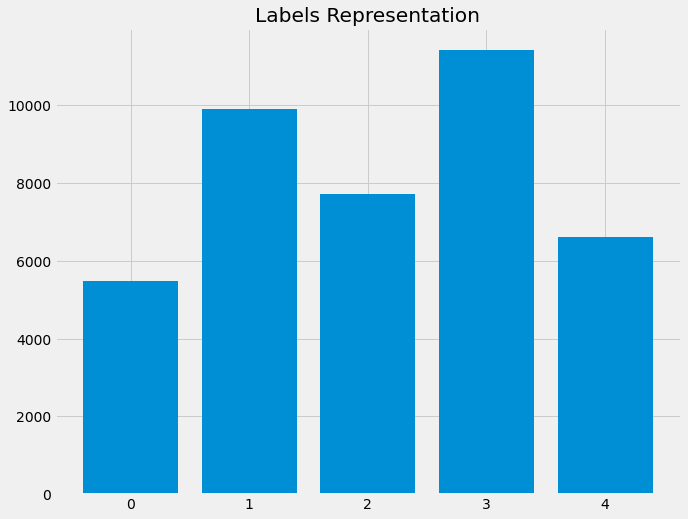

In [13]:
plt.figure(figsize=[10, 8])
plt.bar(grouped_by_sentiment.index, grouped_by_sentiment)
plt.title('Labels Representation');

Let's split the data.

In [14]:
x_train, y_train = data['OriginalTweet'], data['Sentiment']
x_test, y_test = data_test['OriginalTweet'], data_test['Sentiment']

In [15]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(x_train)

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...



In [16]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
x_train = pad_sequences(x_train, maxlen=MAX_NUM_WORDS, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_NUM_WORDS, padding='post', truncating='post')

Transforms each text in texts to a sequence of integers.



In [18]:
x_train.shape, x_test.shape

((41157, 400), (3798, 400))

Let's one hot encode the labels.

In [19]:
y_train = tf.one_hot(y_train, 5)
y_test = tf.one_hot(y_test, 5)

## Evaluation tools and creating Base model

We already observed some unbalance in the data but we concluded that it's not that disastrous. Which is why we'll continue to show the accuracy even as secondary metric.

We'll use the F1 Score and confusion matrix to evaluate the model and we'll intervent and stop the model if the validation loss stops decreasing.

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
f1_score = tfa.metrics.F1Score(CLASS_NUM, name = 'f1_score', average = 'macro')

In [22]:
lstm_biderect = Sequential([
                            Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSIONS),
                            Bidirectional(LSTM(300, dropout=0.9)),
                            Dense(5, activation='softmax')
])

In [23]:
lstm_biderect.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [24]:
history = lstm_biderect.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/100
129/129 [==============================] - 41s 276ms/step - loss: 1.5676 - accuracy: 0.2767 - f1_score: 0.1536 - val_loss: 1.5231 - val_accuracy: 0.3101 - val_f1_score: 0.2353
Epoch 2/100
129/129 [==============================] - 35s 273ms/step - loss: 1.5153 - accuracy: 0.3035 - f1_score: 0.1915 - val_loss: 1.4832 - val_accuracy: 0.3322 - val_f1_score: 0.1932
Epoch 3/100
129/129 [==============================] - 36s 276ms/step - loss: 1.4856 - accuracy: 0.3225 - f1_score: 0.2179 - val_loss: 1.4591 - val_accuracy: 0.3564 - val_f1_score: 0.2318
Epoch 4/100
129/129 [==============================] - 36s 279ms/step - loss: 1.4592 - accuracy: 0.3359 - f1_score: 0.2484 - val_loss: 1.4280 - val_accuracy: 0.3711 - val_f1_score: 0.2527
Epoch 5/100
129/129 [==============================] - 36s 280ms/step - loss: 1.4345 - accuracy: 0.3504 - f1_score: 0.2730 - val_loss: 1.3904 - val_accuracy: 0.4008 - val_f1_score: 0.3296
Epoch 6/100
129/129 [==============================] - 36s 2

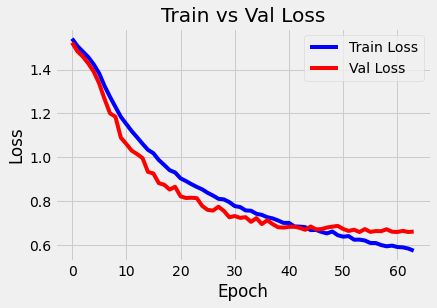

In [25]:
plt.plot(history.history['loss'], c = 'blue', label='Train Loss')
plt.plot(history.history['val_loss'], c='red', label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Val Loss');

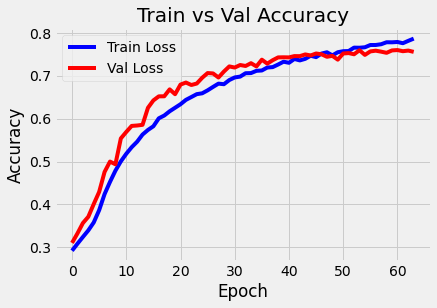

In [27]:
plt.plot(history.history['accuracy'], c = 'blue', label='Train Loss')
plt.plot(history.history['val_accuracy'], c='red', label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Val Accuracy');

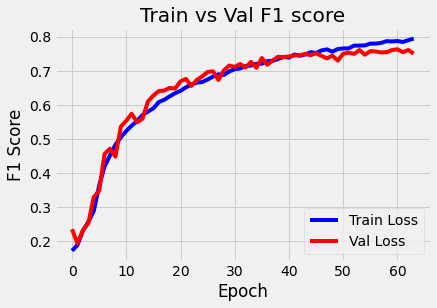

In [26]:
plt.plot(history.history['f1_score'], c = 'blue', label='Train Loss')
plt.plot(history.history['val_f1_score'], c='red', label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Train vs Val F1 score');

**Testing with new data**

In [28]:
lstm_biderect.evaluate(x_test, y_test)

119/119 [==============================] - 3s 22ms/step - loss: 0.7333 - accuracy: 0.7280 - f1_score: 0.7368


[0.7332999110221863, 0.7280147671699524, 0.7367795705795288]

We received very similar results in testing data. This is not unexpected considering the learning curves. Our model has a lot of room for improvement.

## Deeper digging into model's performance

In [52]:
predictions = lstm_biderect.predict(x_test)

In [53]:
def decode_one_hot_encoded(arr):
  np_to_python_list = list(arr)
  get_max = max(np_to_python_list)
  get_index = np_to_python_list.index(get_max)
  return get_index

In [54]:
predictions = [decode_one_hot_encoded(x) for x in predictions]
y_test = [decode_one_hot_encoded(x) for x in y_test]

In [58]:
predictions = [x for x in predictions]

In [66]:
conf_matrix = confusion_matrix(predictions, y_test)

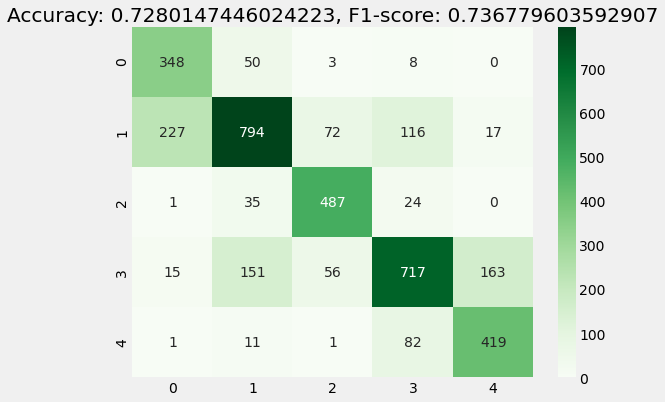

In [78]:
plt.figure(figsize = [8, 6])
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens')
plt.title(f'Accuracy: {accuracy_score(predictions, y_test)}, F1-score: {f1_score(predictions, y_test, average="macro")}');

## Conclusion and continuation

We  don't have the popular problem with unbalanced datasets - we don't confuse or ignore one of the least represented labels. From the confusion matrix and the high F1 Score we can see that our bidirectional lstm RNN is learning to recognize all the labels. But it's not that strong and it requires more training and hyperparameters tuning.

The biggest confusion is between the extremely positive and positive and extremely negative and negative labels respectively. Some people would solve it by simply concatenating them into one label, but we want to contunue with the task as it is. 

We can also turn the task into regression by trying to display how positive or negative a specific tweet is. 